In [31]:
# Import required libraries
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2


In [32]:
# Define paths to the dataset
train_dir = "kidney_split_dataset/train"
test_dir = "kidney_split_dataset/test"
validation_dir = "kidney_split_dataset/validation"

# Define the categories
categories = ["Cyst", "Normal", "Stone", "Tumor"]

# Corresponding class labels
class_labels = [0, 1, 2, 3]
class_counts = [3709, 5077, 1377, 2283]  # Number of images per class


In [33]:
# Function to load images and labels from a directory
def load_data_from_directory(directory, image_size=(128, 128)):
    data = []
    labels = []
    for category in categories:
        folder_path = os.path.join(directory, category)
        class_label = categories.index(category)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            try:
                # Load and preprocess the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                image = cv2.resize(image, image_size)  # Resize to uniform size
                data.append(image.flatten())  # Flatten the image
                labels.append(class_label)  # Append the corresponding label
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    return np.array(data), np.array(labels)

# Load the datasets
X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)
X_val, y_val = load_data_from_directory(validation_dir)


In [34]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [35]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=np.concatenate([np.full(count, label) for label, count in zip(class_labels, class_counts)])
)

# Convert to dictionary
class_weight_dict = dict(zip(class_labels, class_weights))
print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {0: 0.8389053653275815, 1: 0.6128619263344495, 2: 2.259622367465505, 3: 1.3628996933858957}


In [36]:
# Train the SVM with RBF kernel and class weights
svm_model = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight=class_weight_dict, random_state=42)
svm_model.fit(X_train, y_train)


SVC(C=0.1,
    class_weight={0: 0.8389053653275815, 1: 0.6128619263344495,
                  2: 2.259622367465505, 3: 1.3628996933858957},
    random_state=42)

In [37]:
# Predict on the validation set
y_val_pred = svm_model.predict(X_val)

# Generate classification report and accuracy
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=categories))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.98      0.98       371
      Normal       1.00      0.97      0.99       508
       Stone       0.94      0.98      0.96       138
       Tumor       0.97      1.00      0.98       229

    accuracy                           0.98      1246
   macro avg       0.97      0.98      0.98      1246
weighted avg       0.98      0.98      0.98      1246

Validation Accuracy: 0.9815409309791332


In [ ]:
# Predict on the test set
y_test_pred = svm_model.predict(X_test)

# Generate classification report and accuracy
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=categories))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Test Classification Report:
              precision    recall  f1-score   support

        Cyst       0.97      0.99      0.98       371
      Normal       0.99      0.96      0.97       508
       Stone       0.97      0.93      0.95       138
       Tumor       0.92      0.99      0.95       229

    accuracy                           0.97      1246
   macro avg       0.96      0.97      0.97      1246
weighted avg       0.97      0.97      0.97      1246

Test Accuracy: 0.9703049759229535


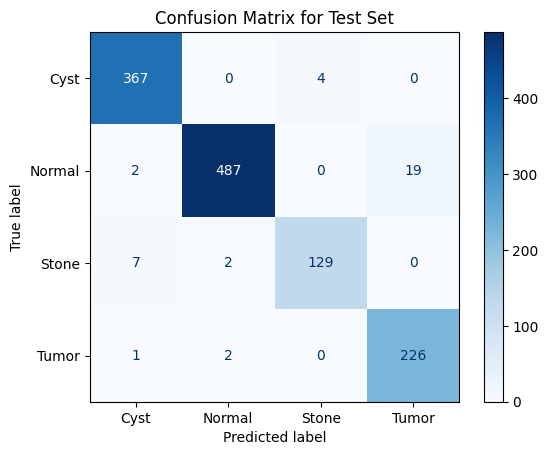

In [39]:
# Plot the confusion matrix for the test set
# Predict on the test set
y_test_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()
